## Customer Segmentation using K-Means Clustering

We will be using the CRISP-DM methodology for this data science project.

### Stage 1: Business Understanding
#### Problem Statement
Your client owns a large mall and has some basic data about their customers such as Customer ID, age, gender, annual income, and spending score. Youa re tasked with clustering the customers in such a way that you can provide meaningful insights that the marketing team can use in a customer marketing strategy.

#### Objectives
* Use $k$-means clustering to segment the customers
* Find the optimum number of customer clusters
* Determine target customers for the marketing strategy
* Explain how the marketing strategy works in the real world

#### Definitions of Success
* The optimum number of clusters

#### Presentation
* Dashboard
* Cloud application

#### Timelines
* 1 week

In [1]:
# Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

In [2]:
# Visualisation theme
sns.set_theme(style='white')
sns.set_context('notebook')
palette_single = '#7C0000'
palette_binary = {'Male': '#7C0000', 'Female': '#BE8080'}
palette_clusters = ['#FFA800', '#7C0000', '#E89871', '#257575', '#2767E1', '#FFE5B3']

# Custom functions
def corr_coef(x, y, label=None, colour=None, **kwargs):
    # get current axis and calculate correlation coefficient
    ax = plt.gca()
    r = np.corrcoef(x, y)[0, 1]
    # add annotation to PairGrid
    ax.annotate('r = {:.3f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', color=colour)

In [3]:
# Load data
df = pd.read_csv('data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Stage 2: Data Understanding
#### Data Quality
| Data Quality Issues | Treatment Options |
|---------------------|-------------------|
| Missing values | No missing values |
| Outliers | Cannot be determined prior to clustering |
| Normalised data | Data requires normalisation |
| Features | Drop `CustomerID` and convert `Gender` to categorical data type |

In [4]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# Check that values are in range
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


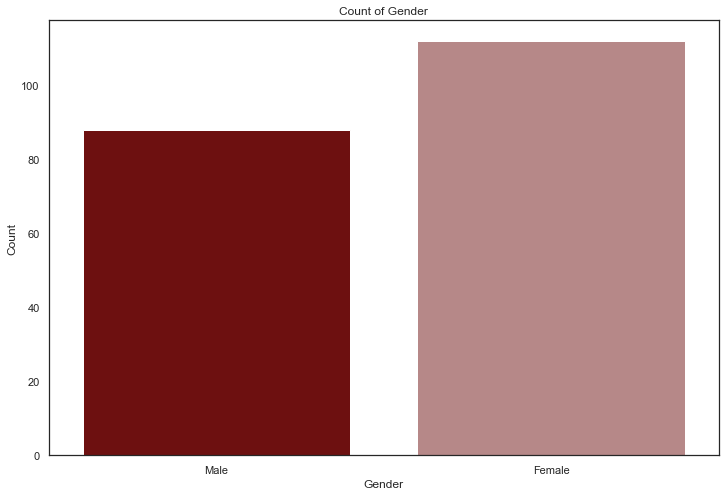

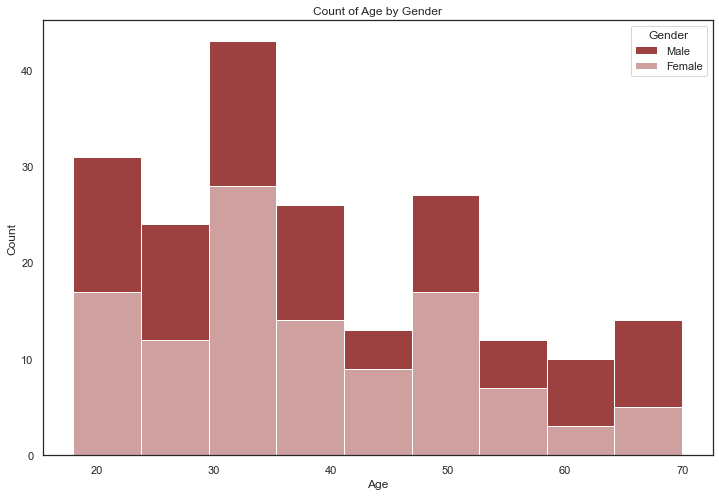

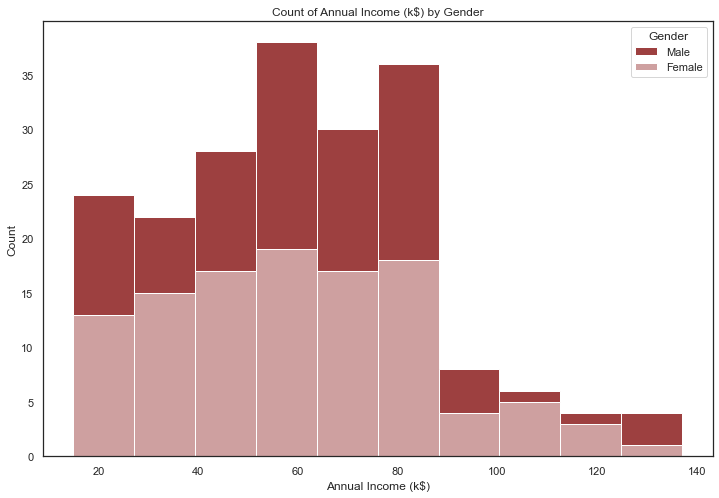

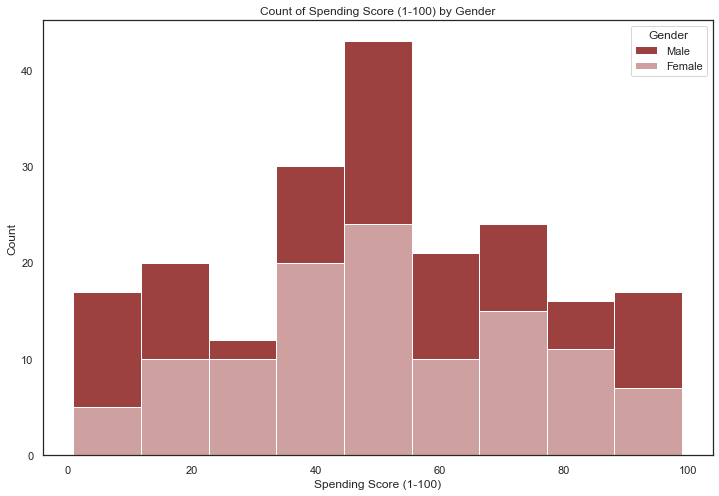

In [6]:
# Distribution plots
for var in df.columns[1:]:
    plt.figure(figsize=(12, 8))
    if var=='Gender':
        df_gender = pd.DataFrame(df['Gender'].value_counts()).reset_index().sort_values(by='Gender', ascending=True)
        df_gender.rename(columns={'Gender': 'Count', 'index': 'Gender'}, inplace=True)
        sns.barplot(data=df_gender, x=var, y='Count', 
                    palette=palette_binary).set(title='Count of '+var)
    else:
        sns.histplot(data=df, x=var, hue='Gender', 
                     multiple='stack', palette=palette_binary).set(title='Count of '+var+' by Gender')
    plt.show()

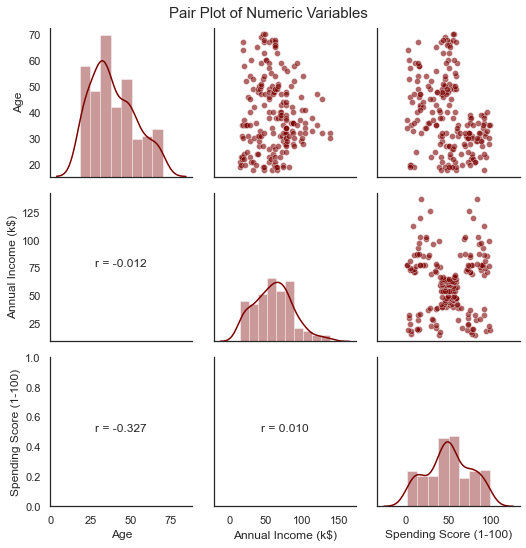

In [7]:
# Show correlations and distribution
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

grid = sns.PairGrid(df, vars=numeric_cols)
grid.map_diag(sns.distplot, color=palette_single)
grid.map_upper(sns.scatterplot, alpha=0.6, color=palette_single)
grid.map_lower(corr_coef, color=palette_single)
plt.suptitle('Pair Plot of Numeric Variables', size=15, y=1.01)
plt.show()

### Stage 3: Data Preparation
This is where we address the data quality issues from Stage 2.

In [8]:
# Drop `CustomerID` and convert `Gender` to categorical type
customer_id = df.pop('CustomerID')
df['Gender'] = df['Gender'].astype('category')

In [9]:
# Normalise the data
transformer = Normalizer()
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X_transformed = transformer.fit_transform(X)

### Stage 4: Modelling
We will be using the $k$-means clustering method for all models - the only things that need to be changed are the parameters and metrics.

#### Baseline Model
For the baseline model, we will just use the default methods and values for each item.

| Item type | Item | Method | Reason for use |
|-----------|------|--------|----------------|
| Parameter | Number of clusters ($k$) | Square root of the number of observations | Default method |
| Parameter | Initialisation method | Random | Default method |
| Parameter | Maximum iterations | 300 | Default value |
| Parameter | $k$-means algorithm to use | Lloyd | Default algorithm |
| Metric | Distance metric | Euclidean distance | Default metric |

#### Selecting initial k: Elbow method

In [10]:
# Get within-cluster sum of squares (WCSS) for each k
wcss = []
cluster_max = int(np.sqrt(X_transformed.shape[0])) + 5

for i in range(1, cluster_max):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

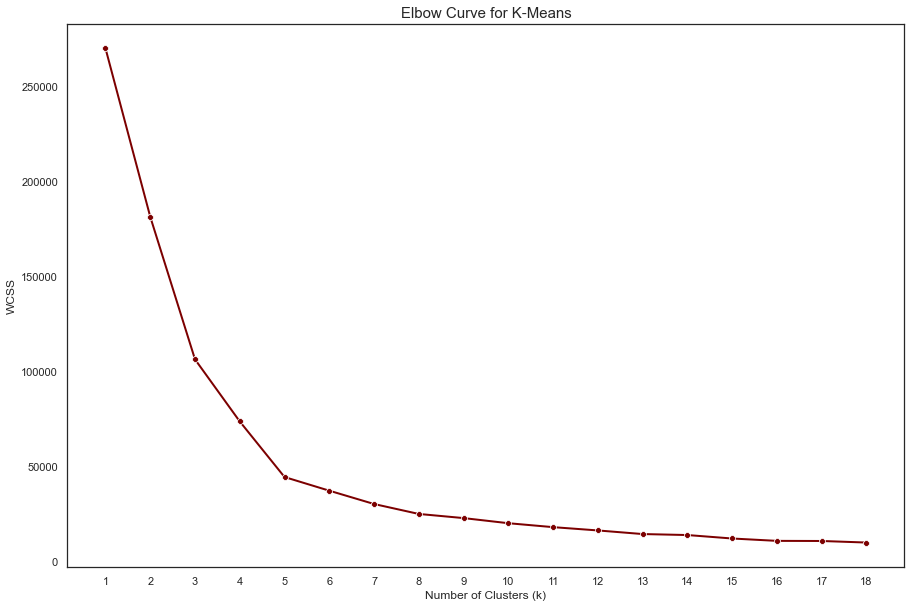

In [11]:
# Plot the elbow curve
plt.figure(figsize=(15,10))
sns.lineplot(x=range(1, cluster_max), y=wcss, linewidth=2, color=palette_single, marker='8')
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(1, cluster_max, 1))
plt.ylabel('WCSS')
plt.title('Elbow Curve for K-Means', size=15)
plt.show()

In [12]:
# Select k
k = 5

#### Further models
We can play around with the parameters and distance metrics until we get a model that works best for our project needs.

### Stage 5: Evaluation

In [13]:
# Fitting to the input data with k=5
kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
kmeans.fit(X)

# Predict the labels of the input data
df_2d = df.copy()
df_2d['Cluster'] = kmeans.predict(X)
df_2d.insert(loc=0, column='CustomerID', value=customer_id)
df_2d

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,1
2,3,Female,20,16,6,2
3,4,Female,23,16,77,1
4,5,Female,31,17,40,2
...,...,...,...,...,...,...
195,196,Female,35,120,79,0
196,197,Female,45,126,28,3
197,198,Male,32,126,74,0
198,199,Male,32,137,18,3


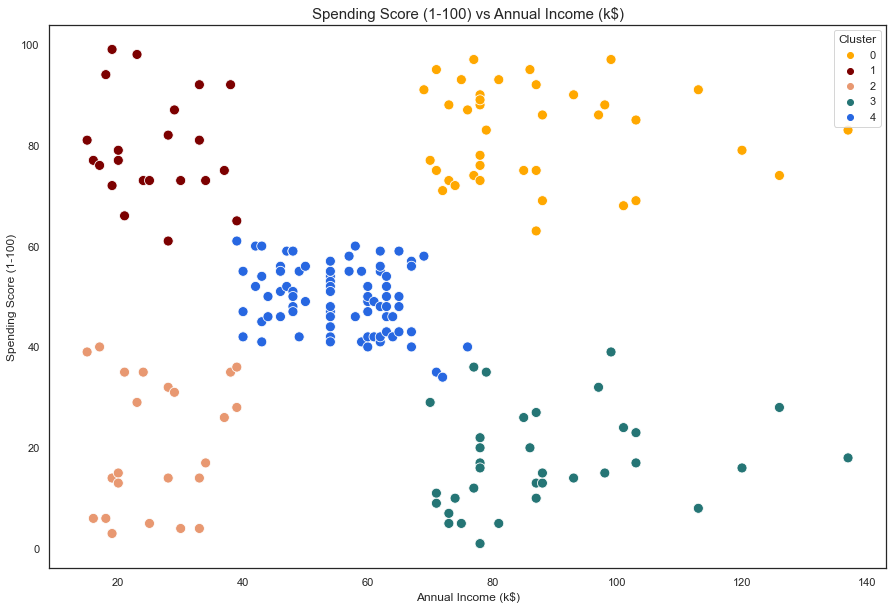

In [14]:
# Scatterplot of the clusters
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_2d, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster',
                palette=palette_clusters[:k], legend='full', s=100)
plt.title('Spending Score (1-100) vs Annual Income (k$)', size=15)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [15]:
# Check cluster sizes
pd.DataFrame(df_2d.groupby('Cluster')['CustomerID'].count())

,CustomerID
Cluster,
0,39
1,22
2,23
3,35
4,81


In [16]:
# Show customer IDs within each cluster
for clust in df_2d['Cluster'].sort_values().unique():
    print('Cluster:', clust)
    print(np.array(df_2d[df_2d['Cluster']==clust]['CustomerID']), '\n')

Cluster: 0
[124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158
 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194
 196 198 200] 

Cluster: 1
[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 46] 

Cluster: 2
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45] 

Cluster: 3
[125 129 131 135 137 139 141 145 147 149 151 153 155 157 159 161 163 165
 167 169 171 173 175 177 179 181 183 185 187 189 191 193 195 197 199] 

Cluster: 4
[ 44  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 127 133 143] 



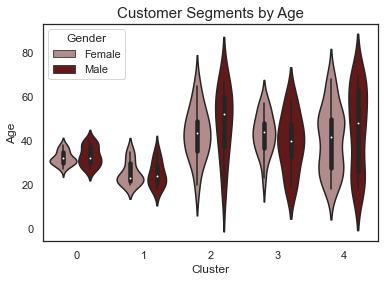

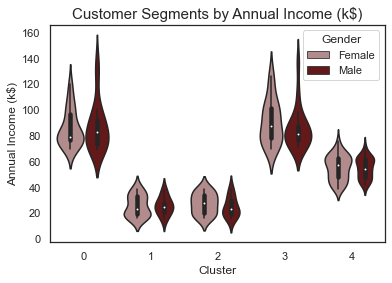

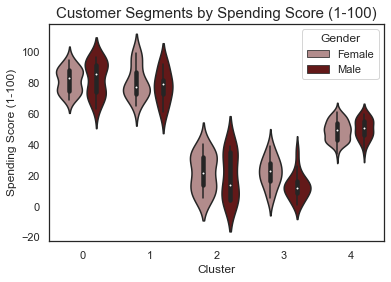

In [17]:
# Visualise the clusters however you like
for var in numeric_cols:
    sns.violinplot(data=df_2d, x='Cluster', y=var, hue='Gender', scale='count', palette=palette_binary, saturation=0.6)
    plt.title('Customer Segments by '+ var, size=15)
    plt.show()

### 3D Data
Let's perform the above steps using three features.

In [18]:
# Normalise the data
transformer = Normalizer()
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_transformed = transformer.fit_transform(X)

In [19]:
# Initialise the k-means method
wcss = []
cluster_max = int(np.sqrt(X_transformed.shape[0])) + 5

for i in range(1, cluster_max):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

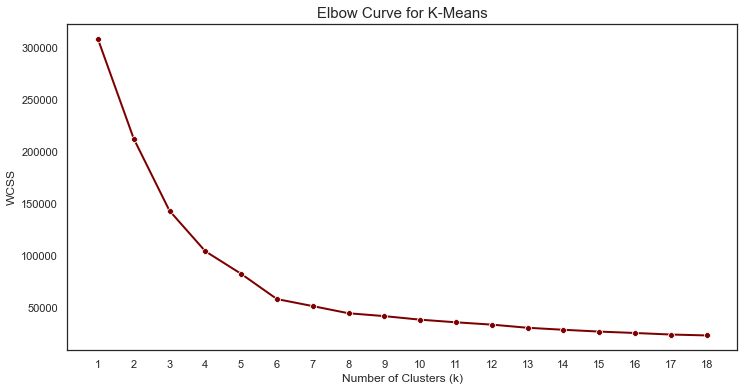

In [20]:
# Plot the elbow curve
plt.figure(figsize=(12,6))
sns.lineplot(x=range(1, cluster_max), y=wcss, linewidth=2, color=palette_single, marker='8')
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(1, cluster_max, 1))
plt.ylabel('WCSS')
plt.title('Elbow Curve for K-Means', size=15)
plt.show()

In [21]:
# Select k
k = 6

In [22]:
# Fitting to the input data with k=6
kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
kmeans.fit(X)

# Predict the labels of the input data
df_3d = df.copy()
df_3d['Cluster'] = kmeans.predict(X)
df_3d.insert(loc=0, column='CustomerID', value=customer_id)
df_3d

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,1
2,3,Female,20,16,6,2
3,4,Female,23,16,77,1
4,5,Female,31,17,40,2
...,...,...,...,...,...,...
195,196,Female,35,120,79,4
196,197,Female,45,126,28,3
197,198,Male,32,126,74,4
198,199,Male,32,137,18,3


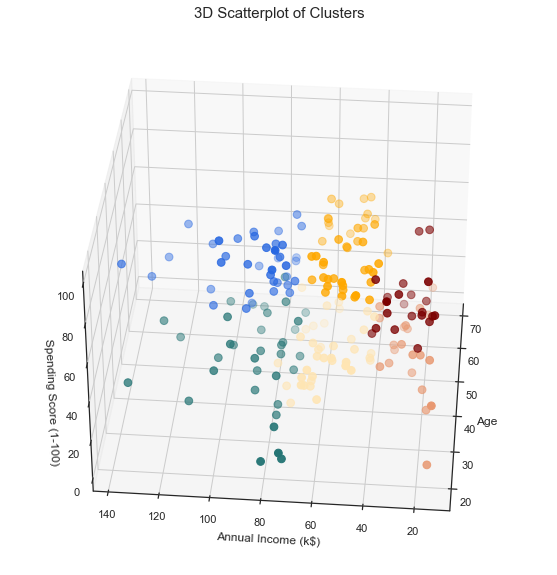

In [23]:
# 3D scatterplot of the clusters
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(k):
    ax.scatter(df_3d['Age'][df_3d['Cluster']==i], df_3d['Annual Income (k$)'][df_3d['Cluster']==i], df_3d['Spending Score (1-100)'][df_3d['Cluster']==i], c=palette_clusters[i], s=60)
ax.view_init(35, 185)
plt.title('3D Scatterplot of Clusters', size=15)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [24]:
# Check cluster sizes
pd.DataFrame(df_3d.groupby('Cluster')['CustomerID'].count())

,CustomerID
Cluster,
0,44
1,22
2,22
3,35
4,39
5,38


In [25]:
# Show customer IDs within each cluster
for clust in df_3d['Cluster'].sort_values().unique():
    print('Cluster:', clust)
    print(np.array(df_3d[df_3d['Cluster']==clust]['CustomerID']), '\n')

Cluster: 0
[ 41  47  51  54  55  56  57  58  60  61  63  64  65  67  68  71  72  73
  74  75  77  80  81  83  84  86  87  90  91  93  97  99 102 103 105 107
 108 109 110 111 117 118 119 120] 

Cluster: 1
[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 46] 

Cluster: 2
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 43 45] 

Cluster: 3
[127 129 131 135 137 139 141 145 147 149 151 153 155 157 159 161 163 165
 167 169 171 173 175 177 179 181 183 185 187 189 191 193 195 197 199] 

Cluster: 4
[124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158
 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194
 196 198 200] 

Cluster: 5
[ 44  48  49  50  52  53  59  62  66  69  70  76  78  79  82  85  88  89
  92  94  95  96  98 100 101 104 106 112 113 114 115 116 121 122 123 125
 133 143] 

